# An Examination of AI and Machine Learning Techniques for Stock Market Predictions
### Can stock price movement be predicted using historic stock market data?

<center>
    <img src = images/stock-banner.jpg width = 100%/>
</center>


## Business Understanding


**OVERVIEW**

Being able to predict stock price movement can help inform investment decisions. If a stock is predicted to go up within a particular timeframe, it can be bought, held for that period, and then sold for a gain.

The goal of this project is to determine whether a model can be developed to predict the days on which a stock is expected to rise—using historical data—with better results than buying on random days. Ideally, if a trader buys only on days indicated by the model, they would expect a net gain over losses.

Additionally, with a significant amount of AI already guiding institutional investment decisions, there may be some regularity and predictability in the data. It will be interesting to see if momentum trends can be identified for common stocks.

**Data**

Historical stock price data from Yahoo! Finance stocks including historic prices, volume, dividends and other stock metrics such as a volatility index.

**Processing Techniques**

The investigation will be framed as a classification problem: Will the historical inputs result in a classification of the price as "Up" or "Down"?

The raw historical stock data—including price, volume, and dividends—will be used. The following engineered features, calculated from existing data, will be employed:

* Historic Prices: Price of the stock x-days back
* Historic Deltas: Difference between today's opening price and that from x-days ago.
* Horizons: Ratio of current price to an x-day average
* Number of Days of Stock Increases: Count of days the stock increased.

For the training dataset, an "Up" or "Down" result is calculated based on whether the stock increased or decreased in value from the previous day's opening price.

Decision Trees, K-Nearest Neighbors (KNN), and Support Vector Machines (SVM) models—with various hyper-parameters tuned using GridSearch—will be used to perform the classification.

**Expected Results**

It is expected that some momentum exists in the market based on fundamentals, so some correlation should be observable in at least certain time frames for some stocks.

## Methodology: CRISP-DM Framework
For this application, an industry standard model called CRISP-DM is used.  This process provides a framework for working through a data problem.  



<center>
    <img src = images/crisp.png width = 50%/>
</center>

<center>
    <img src = images/CRISP-DM-Methodology.png width = 80%/>
</center>




## Data Understanding & Data Preparation


To understand data  and quality of the Yahoo! Finance data, the following steps will be performed:
1. Collect Initial Data - Load Data
2. Describe Data & Data Quality - Understand Fields
3. Explore Data - Understand data values, statistic relevance

This information will be used to guide the Business Understanding and for construction. 

### 1. Collect Initial Data - Load Data
The source of the data was Yahoo Finance: 

https://finance.yahoo.com/

A five year time window was selected to get sufficient data necessary for training of approximately 1000 daily records. More than 1000 records were collected to allow for capture of time series data. 

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
import math as math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import sklearn.metrics as metrics
import time

In [3]:
# Read Data

symbol = 'AAPL'
price_df = pd.read_csv('data/' + symbol + '-price.csv')
dividend_df = pd.read_csv('data/' + symbol + '-dividend.csv')
vix_df = pd.read_csv('data/^VIX.csv')

In [4]:
#Read Prototyped Data in Excel
#symbol = 'AAPL'
#nom_data = pd.read_csv('draft/AAPL-csv.csv').dropna()

#nom_data

### 2. Describe Data & Data Quality - Understand Fields

For this exercise, a single stock, Apple Computer (AAPL) was examined. The dataset from Yahoo! Finance provides the following fields:

* Date - Date of the values 
* Open - Opening price (Note: This is not the closing price as the initial sale is negotiated after closing due to after hours trading)
* High - High price of the day
* Low - Low price of the date
* Close - Price at closing
* Adj Close - Price taking into account dividends and other factors (not used in this exercise)
* Volume - Number of trades on this day

* Dividend Date - Date a cash dividend was issued
* Dividend Amount - Amount per share 


The quality of the data from Yahoo! Finance is good. There are no missing values for any rows. 

In [5]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [6]:
price_df.head(7)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-16,60.487499,64.769997,60.000000,60.552502,58.779289,322423600
1,2020-03-17,61.877499,64.402496,59.599998,63.215000,61.363823,324056000
2,2020-03-18,59.942501,62.500000,59.279999,61.667500,59.861637,300233600
3,2020-03-19,61.847500,63.209999,60.652500,61.195000,59.402977,271857200
4,2020-03-20,61.794998,62.957500,57.000000,57.310001,55.631741,401693200
5,2020-03-23,57.020000,57.125000,53.152500,56.092499,54.449898,336752800
6,2020-03-24,59.090000,61.922501,58.575001,61.720001,59.912598,287531200


In [7]:
price_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,160.196888,161.961691,158.537315,160.334308,158.489126,8.565798e+07
std,41.203216,41.431059,40.987410,41.248418,41.899680,4.778116e+07
min,57.020000,57.125000,53.152500,56.092499,54.449898,2.025219e+07
25%,133.800003,135.020004,131.929993,133.580002,130.838745,5.376350e+07
50%,158.740005,160.449997,155.800003,157.830002,155.828522,7.353180e+07
75%,183.449997,184.960007,181.919998,183.789993,182.436859,1.012356e+08
max,258.190002,260.100006,257.630005,259.019989,258.735504,4.016932e+08


In [8]:
dividend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       20 non-null     object 
 1   Dividends  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes


In [9]:
dividend_df.describe()

,Dividends
count,20.000000
mean,0.229000
std,0.016026
min,0.205000
25%,0.220000
50%,0.230000
75%,0.240000
max,0.250000


In [10]:
#Count number of rows with NAs in any column
na_count = price_df.isna().any(axis=1).sum()
print(f"Number of rows with NA in any column: {na_count}")

Number of rows with NA in any column: 0


### 3. Explore Data - Perform Exploratory Data Analysis (EDA)
Perform a series of plots to understand the data and intuitively see if there are any correlations to the target price feature. Identify Data Anomalies in the dataset. 
For this use case, I believe that outliers are important as they represent major events which greatly affect the outcome and should be captured and included in the dataset.  Specific analysis below.


#### Price and Volume Data

The open and close prices look like they remain close on most days. Since the scenario is to produce a tool for traders to action at the start of their day, the market open price can be used as input to the model. 

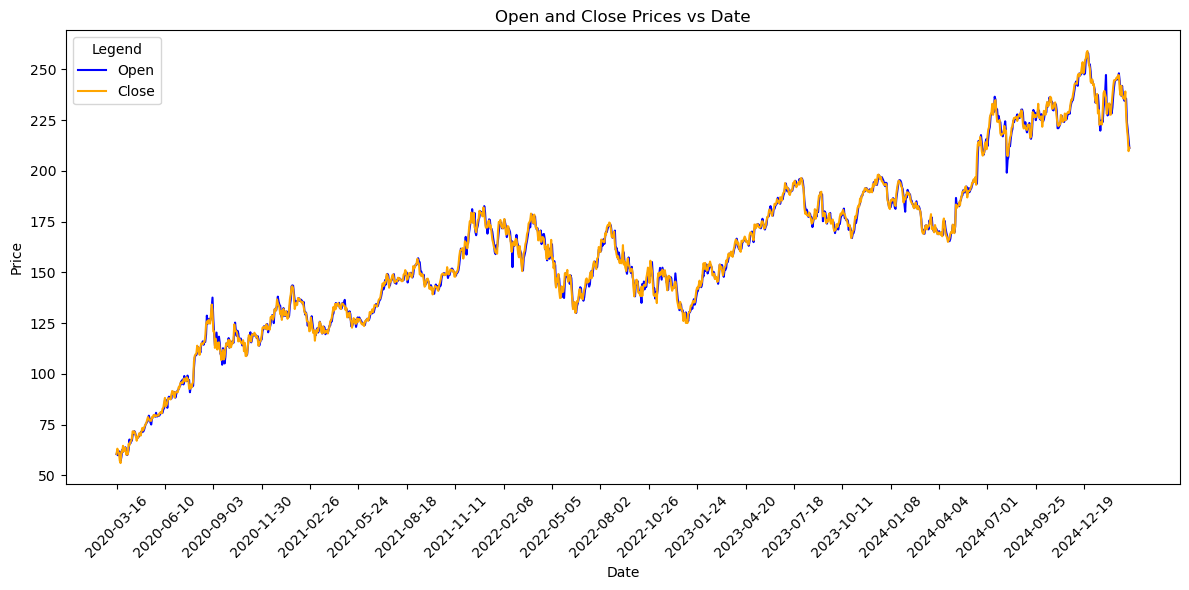

In [11]:
# Plot Open and Close on the same graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Open prices
sns.lineplot(data=price_df, x="Date", y="Open", ax=ax, label="Open", color="blue")

# Plot Close prices
sns.lineplot(data=price_df, x="Date", y="Close", ax=ax, label="Close", color="orange")

# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Open and Close Prices vs Date")
ax.legend(title="Legend")
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
ax.set_xticks(ax.get_xticks()[::60])  # Set x-axis ticks every 60 entries

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Statistical Analysis of Close Prices

It does not appear that closing prices of this stock does not follow a normal distribution. This is likely due to several factors including the fact the stock factors are related to company performance and external factors that are also not gaussian in nature.  Since the stock is modeled generally increasing in price holding steady in the middle, there are not many outliers in the data as can be seen in the box plot.

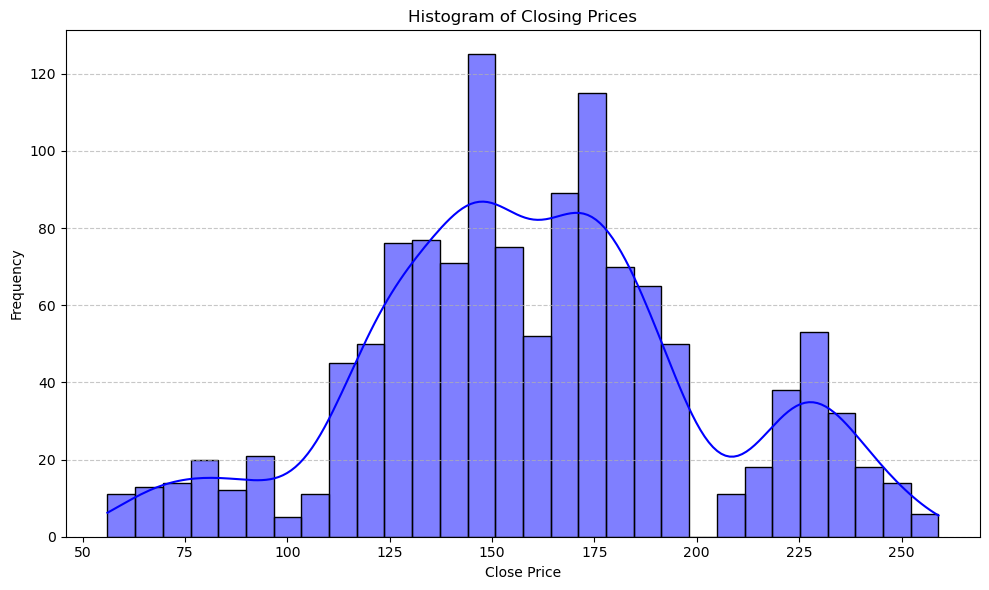

,Close
count,1257.000000
mean,160.334308
std,41.248418
min,56.092499
25%,133.580002
50%,157.830002
75%,183.789993
max,259.019989


In [12]:
# Create a histogram of the Close prices

plt.figure(figsize=(10, 6))
sns.histplot(price_df['Close'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
price_df[['Close']].describe()

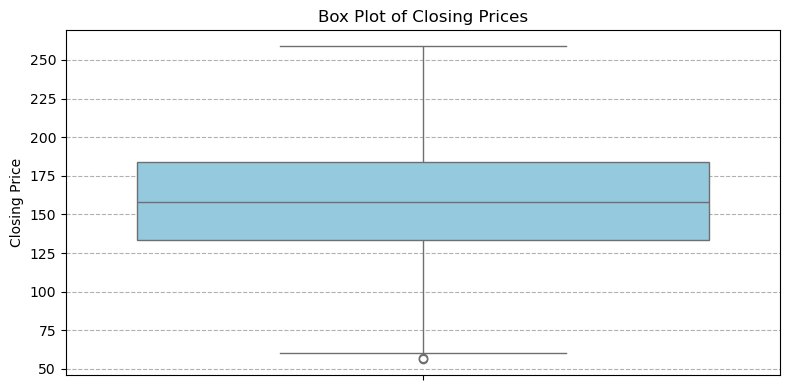

In [13]:
# Create a box plot for the closing price
plt.figure(figsize=(8, 4))
sns.boxplot(data=price_df, y='Close', color='skyblue')

# Customize the plot
plt.title('Box Plot of Closing Prices')
plt.ylabel('Closing Price')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

#### Statistical Analysis of Volume

While trading volume follows a roughly normal distribution, it is very skewed towards large trades. Numerical analysis confirms this skew with a coefficient of over two. The box plot showing outliers also show significant number of trades that were outliers on the high side. This could be due to a high number of institutional investors that react upon certain market changes with big trades.

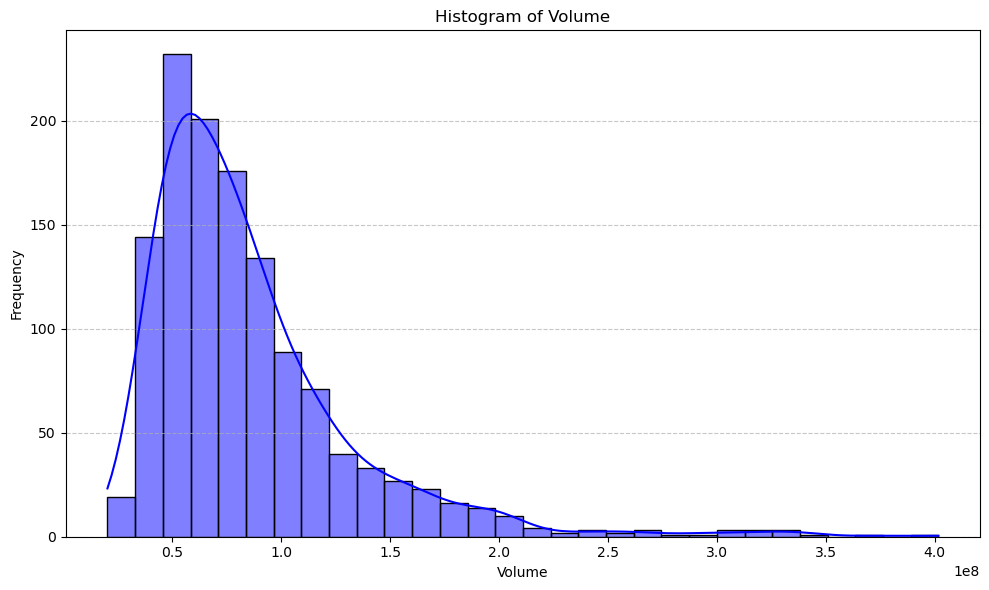

Skew Coefficient: 2.2698125481974287


,Volume
count,1.257000e+03
mean,8.565798e+07
std,4.778116e+07
min,2.025219e+07
25%,5.376350e+07
50%,7.353180e+07
75%,1.012356e+08
max,4.016932e+08


In [14]:
# Create a histogram of Volume
plt.figure(figsize=(10, 6))
sns.histplot(price_df['Volume'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

skewCoef = price_df['Volume'].skew()
print(f"Skew Coefficient: {skewCoef}")

price_df[['Volume']].describe()

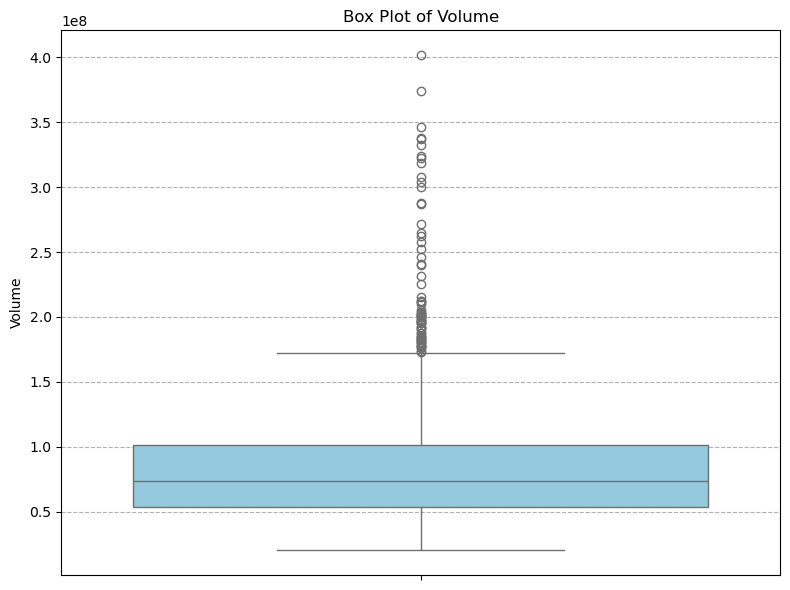

In [15]:
# Create a box plot for the Volume column
plt.figure(figsize=(8, 6))
sns.boxplot(data=price_df, y='Volume', color='skyblue')

# Customize the plot
plt.title('Box Plot of Volume')
plt.ylabel('Volume')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

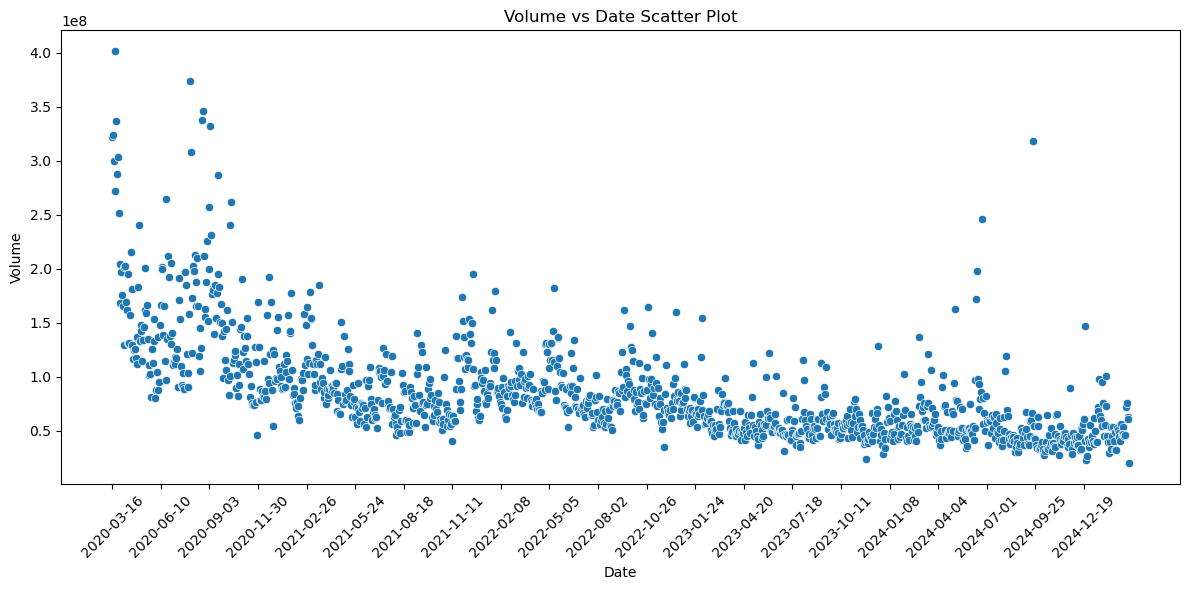

In [16]:
#Plot Volume
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for Open

# Scatter plot for Volume
sns.scatterplot(data=price_df, x="Date", y="Volume", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Volume")
ax.set_title("Volume vs Date Scatter Plot")
ax.set_xticks(ax.get_xticks()[::60])  # Set x-axis ticks every 60 entries
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Statistical Analysis of Volatility Index (VIX)
There is some above normal volatility at the beginning of the dataset, which will be excluded from the dataset during feature generation of historical time series data. 

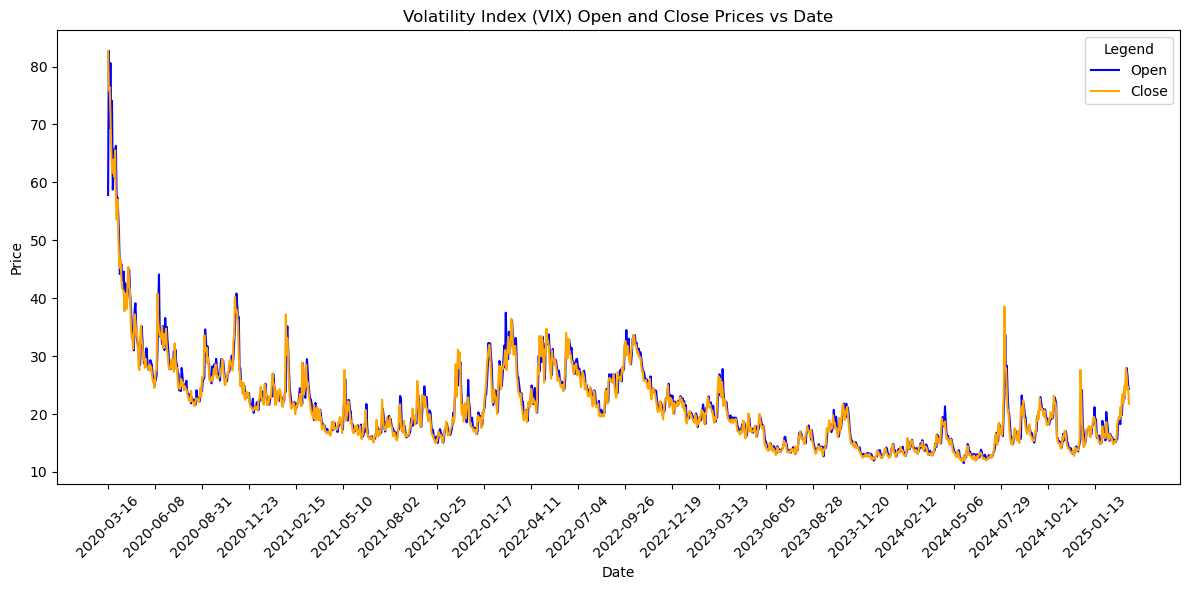

In [17]:
# Plot Open and Close on the same graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Open prices
sns.lineplot(data=vix_df, x="Date", y="Open", ax=ax, label="Open", color="blue")

# Plot Close prices
sns.lineplot(data=vix_df, x="Date", y="Close", ax=ax, label="Close", color="orange")

# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Volatility Index (VIX) Open and Close Prices vs Date")
ax.legend(title="Legend")
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
ax.set_xticks(ax.get_xticks()[::60])  # Set x-axis ticks every 60 entries

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

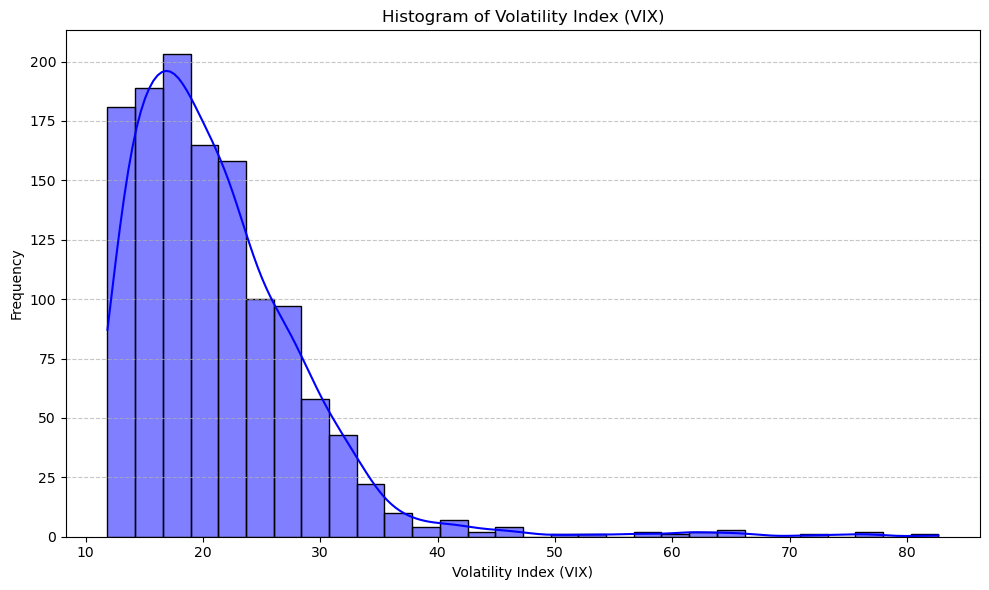

Skew Coefficient: 2.5602950046235846


,Close
count,1257.000000
mean,21.239905
std,7.773636
min,11.860000
25%,16.040001
50%,19.629999
75%,24.660000
max,82.690002


In [18]:
# Create a histogram of VIX
plt.figure(figsize=(10, 6))
sns.histplot(vix_df['Close'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Volatility Index (VIX)')
plt.xlabel('Volatility Index (VIX)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

skewCoef = vix_df['Close'].skew()
print(f"Skew Coefficient: {skewCoef}")

vix_df[['Close']].describe()

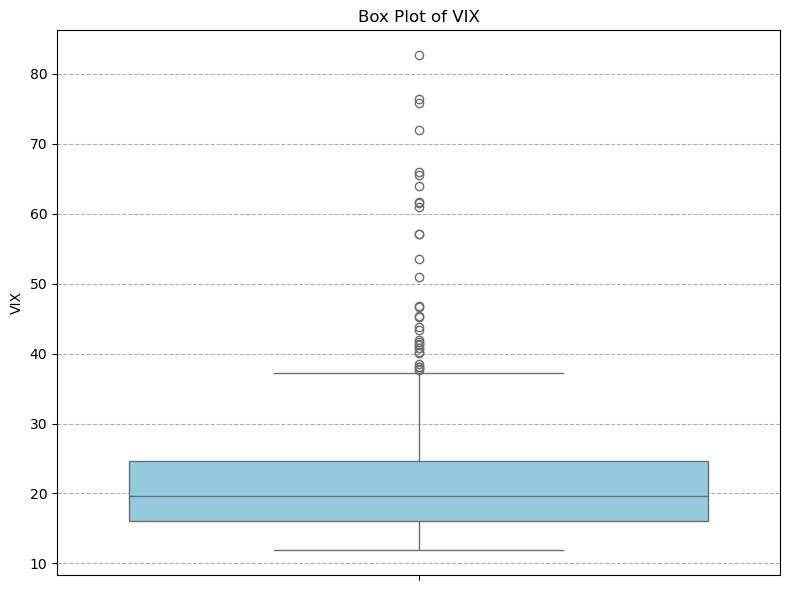

In [19]:
# Create a box plot for the VIX
plt.figure(figsize=(8, 6))
sns.boxplot(data=vix_df, y='Close', color='skyblue')

# Customize the plot
plt.title('Box Plot of VIX')
plt.ylabel('VIX')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

#### Examine Dividends

Dividends appear to be offered at regular intervals of increasing value. From the calculated field "Days Since Dividend", it was seen that there are dividends are generally issued every 90 days, however there are exceptions. This is because dividends are issued quarterly and there is some variation in the schedule due to holidays, etc.

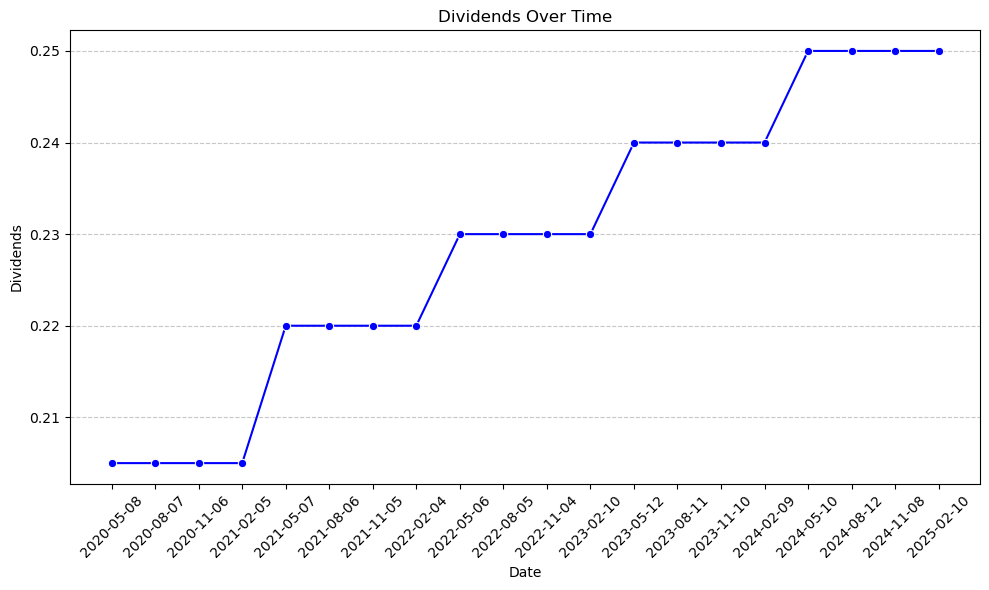

,Date,Dividends
0,2020-05-08,0.205
1,2020-08-07,0.205
2,2020-11-06,0.205
3,2021-02-05,0.205
4,2021-05-07,0.220
5,2021-08-06,0.220
6,2021-11-05,0.220
7,2022-02-04,0.220
8,2022-05-06,0.230
9,2022-08-05,0.230


In [20]:
#Examine Dividends
# Create an x-y chart for dividends
plt.figure(figsize=(10, 6))
sns.lineplot(data=dividend_df, x="Date", y="Dividends", marker="o", color="blue")

# Customize the plot
plt.title("Dividends Over Time")
plt.xlabel("Date")
plt.ylabel("Dividends")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

dividend_df

## Data Preparation

Relevant features for training will be selected. Additionally feature engineering will need to be done for to shift values for time series analysis. Additionally, key metrics such as Horizon indexes can be calculated from the source data. 

The following steps are followed:

1. Construct Data - Derive features 
2. Integrate Data - Produce Dataset 
3. Select Data - Identify Features that drive the result


As the data was of good quality, data cleaning and data formatting was not required. All features examined were numeric in nature. The date format in all files were consistent in format allowing it to be used as an index. All files had values listed in temporal order. 


### 1. Construct Data - Derive features 

To perform the analysis, feature engineering is required to bring historic and calculated values into one row of the DataFrame to train the model. 

1. Previous Close to Open
2. Volume 1-day, 2-day
3. Close 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
4. Delta 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
5. VIX 1-day, 2-day, 3-day
6. Last Dividend Amount, Last Dividend Date, Days Since Dividend
7. Horizon Ratio 2-day, 1-week, 1-month
8. Increases 1-day, 2-day, 1-week, 1-month
9. Daily Close Change, Up or Down

In [21]:
#Handle Shifted Time Calculated Fields

derived_df = pd.DataFrame()

# 1. Previous Close to Open
derived_df['Previous Close to Open'] = price_df['Open'] - price_df['Close'].shift(1)

# 2. Volume 1-day, 2-day
derived_df['Volume 1-day'] = price_df['Volume'].shift(1)
derived_df['Volume 2-day'] = price_df['Volume'].shift(2)

# 3. Close 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
derived_df['Close 1-day'] = price_df['Close'].shift(1)
derived_df['Close 2-day'] = price_df['Close'].shift(2)
derived_df['Close 3-day'] = price_df['Close'].shift(3)
derived_df['Close 1-week'] = price_df['Close'].shift(5)
derived_df['Close 2-week'] = price_df['Close'].shift(10)
derived_df['Close 1-month'] = price_df['Close'].shift(20)

# 4. Delta 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
derived_df['Delta 1-day'] = price_df['Open'] - price_df['Open'].shift(1)
derived_df['Delta 2-day'] = price_df['Open'] - price_df['Open'].shift(2)
derived_df['Delta 3-day'] = price_df['Open'] - price_df['Open'].shift(3)
derived_df['Delta 1-week'] = price_df['Open'] - price_df['Open'].shift(5)
derived_df['Delta 2-week'] = price_df['Open'] - price_df['Open'].shift(10)
derived_df['Delta 1-month'] = price_df['Open'] - price_df['Open'].shift(20)

# 7. Horizon Ratio 2-day, 1-week, 1-month
derived_df['Horizon Ratio 2-day'] = price_df['Open'] / price_df['Close'].shift(1).rolling(window=2).mean()
derived_df['Horizon Ratio 1-week'] = price_df['Open'] / price_df['Close'].shift(1).rolling(window=5).mean()
derived_df['Horizon Ratio 1-month'] = price_df['Open'] / price_df['Close'].shift(1).rolling(window=20).mean()

# 9. Daily Close Change, Up or Down
derived_df['Daily Close Change'] = price_df['Close'].diff()
derived_df['Up or Down'] = np.where(derived_df['Daily Close Change'] > 0, 'UP', 'DOWN')

# 8. Increases 1-day, 2-day, 1-week, 1-month
derived_df['Increases 1-day'] = np.where(derived_df['Up or Down'].shift(1)=='UP', 1, 0)
derived_df['Increases 2-day'] = derived_df['Increases 1-day'].rolling(window=2).sum()
derived_df['Increases 1-week'] = derived_df['Increases 1-day'].rolling(window=5).sum()
derived_df['Increases 1-month'] = derived_df['Increases 1-day'].rolling(window=21).sum()

# Add 'Date' column to the front
derived_df.insert(0, 'Date', price_df['Date'])

derived_df [160:165]



,Date,Previous Close to Open,Volume 1-day,Volume 2-day,Close 1-day,Close 2-day,Close 3-day,Close 1-week,Close 2-week,Close 1-month,...,Delta 1-month,Horizon Ratio 2-day,Horizon Ratio 1-week,Horizon Ratio 1-month,Daily Close Change,Up or Down,Increases 1-day,Increases 2-day,Increases 1-week,Increases 1-month
160,2020-10-30,-4.260002,146129200.0,143937800.0,115.320000,111.199997,116.599998,115.040001,119.019997,113.019997,...,-1.830001,0.980576,0.968755,0.951084,-6.459999,DOWN,1,1.0,3.0,10.0
161,2020-11-02,0.250000,190272600.0,146129200.0,108.860001,115.320000,111.199997,115.050003,115.980003,116.500000,...,-4.800003,0.973414,0.962118,0.936052,-0.090004,DOWN,0,1.0,3.0,9.0
162,2020-11-03,0.890007,122866900.0,190272600.0,108.769997,108.860001,115.320000,116.599998,117.510002,113.160004,...,-6.039993,1.007766,0.977798,0.943901,1.670005,UP,0,0.0,2.0,9.0
163,2020-11-04,3.699997,107624400.0,122866900.0,110.440002,108.769997,108.860001,111.199997,116.870003,115.080002,...,-0.480004,1.041376,1.029048,0.983614,4.509995,UP,1,1.0,2.0,9.0
164,2020-11-05,3.000000,138235500.0,107624400.0,114.949997,110.440002,108.769997,115.320000,115.750000,114.970001,...,1.699997,1.046630,1.056256,1.016504,4.080002,UP,1,2.0,3.0,10.0


In [22]:
#derived_df.to_csv('draft/derived_data.csv', index=False)

In [23]:
# 5. VIX 1-day, 2-day, 3-day

derived_vix_df = pd.DataFrame()
derived_vix_df = price_df['Date']
derived_vix_df = pd.merge(derived_vix_df, vix_df[['Date', 'Close']], on='Date', how='left')
derived_vix_df['VIX 1-day'] = derived_vix_df['Close'].shift(1)
derived_vix_df['VIX 2-day'] = derived_vix_df['Close'].shift(2)
derived_vix_df['VIX 3-day'] = derived_vix_df['Close'].shift(3)
derived_vix_df.drop(columns=['Close'], inplace=True)

derived_vix_df

,Date,VIX 1-day,VIX 2-day,VIX 3-day
0,2020-03-16,NaN,NaN,NaN
1,2020-03-17,82.690002,NaN,NaN
2,2020-03-18,75.910004,82.690002,NaN
3,2020-03-19,76.449997,75.910004,82.690002
4,2020-03-20,72.000000,76.449997,75.910004
...,...,...,...,...
1252,2025-03-10,23.370001,24.870001,21.930000
1253,2025-03-11,27.860001,23.370001,24.870001
1254,2025-03-12,26.920000,27.860001,23.370001
1255,2025-03-13,24.230000,26.920000,27.860001


In [24]:
#derived_vix_df.to_csv('draft/derived_vix_data.csv', index=False)

**Last Dividend Amount, Last Dividend Date, Days Since Dividend**

Due to the complexity of merging the dividend data and producing these derived attributes, it was considered to omit these features from the analysis. Additionally when observing the relative importance of these factors using PCA, dividend values showed up in the bottom of the list when evaluated by their magnitude (absolute values of coefficients). 

In [25]:
# 6. Last Dividend Amount, Last Dividend Date, Days Since Dividend

derived_dividend_df = pd.DataFrame()

# Ensure 'Date' columns are in datetime format
derived_dividend_df['Date'] = price_df['Date']

# Merge dividend data into derived_dividend_df
derived_dividend_df = pd.merge(derived_dividend_df, dividend_df[['Date', 'Dividends']], on='Date', how='left')

# Forward-fill the last dividend date and value
derived_dividend_df['Last Dividend Date'] = derived_dividend_df['Date'].where(derived_dividend_df['Dividends'].notna()).ffill()
derived_dividend_df['Last Dividend Amount'] = derived_dividend_df['Dividends'].ffill()

derived_dividend_df['Days Since Dividend'] = (pd.to_datetime(derived_dividend_df['Date']) - pd.to_datetime(derived_dividend_df['Last Dividend Date']) ).dt.days

# Drop the 'Dividends' column
derived_dividend_df.drop(columns=['Dividends'], inplace=True)

derived_dividend_df.tail(5)

,Date,Last Dividend Date,Last Dividend Amount,Days Since Dividend
1252,2025-03-10,2025-02-10,0.25,28.0
1253,2025-03-11,2025-02-10,0.25,29.0
1254,2025-03-12,2025-02-10,0.25,30.0
1255,2025-03-13,2025-02-10,0.25,31.0
1256,2025-03-14,2025-02-10,0.25,32.0


In [26]:
#derived_dividend_df.to_csv('draft/derived_dividend_data.csv', index=False)

### 2. Integrate Data - Produce Dataset 

In [ ]:
# Merge all derived dataframes
nom_data = price_df.copy(deep=True)

nom_data = pd.merge(nom_data, derived_df, on='Date', how='left') 
nom_data = pd.merge(nom_data, derived_dividend_df, on='Date', how='left') 
nom_data = pd.merge(nom_data, derived_vix_df, on='Date', how='left') 

renamed_vix_df = vix_df[['Date', 'Open', 'Close']].rename(columns={'Open': 'VIX Open', 'Close': 'VIX Close'})
nom_data = pd.merge(nom_data, renamed_vix_df , on='Date', how='left') 

#Remove rows with NAs. This is due to missing historic values at the beginning of the dataset
nom_data = nom_data.dropna()
nom_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Previous Close to Open,Volume 1-day,Volume 2-day,...,Increases 1-week,Increases 1-month,Last Dividend Date,Last Dividend Amount,Days Since Dividend,VIX 1-day,VIX 2-day,VIX 3-day,VIX Open,VIX Close
38,2020-05-08,76.410004,77.587502,76.072502,77.532501,75.465782,133838400,0.475006,115215200.0,142333600.0,...,4.0,14.0,2020-05-08,0.205,0.0,31.440001,34.119999,33.610001,30.139999,27.980000
39,2020-05-11,77.025002,79.262497,76.809998,78.752502,76.653259,145946400,-0.507499,133838400.0,115215200.0,...,5.0,14.0,2020-05-08,0.205,3.0,27.980000,31.440001,34.119999,28.459999,27.570000
40,2020-05-12,79.457497,79.922501,77.727501,77.852501,75.777260,162301200,0.704995,145946400.0,133838400.0,...,5.0,14.0,2020-05-08,0.205,4.0,27.570000,27.980000,31.440001,28.469999,33.040001
41,2020-05-13,78.037498,78.987503,75.802498,76.912498,74.862305,200622400,0.184997,162301200.0,145946400.0,...,4.0,13.0,2020-05-08,0.205,5.0,33.040001,27.570000,27.980000,32.740002,35.279999
42,2020-05-14,76.127502,77.447502,75.382500,77.385002,75.322205,158929200,-0.784996,200622400.0,162301200.0,...,3.0,12.0,2020-05-08,0.205,6.0,35.279999,33.040001,27.570000,35.160000,32.610001


In [28]:
#nom_data.to_csv('draft/nom_data.csv', index=False)

### 3. Select Data - Identify Features that drive the result

#### List of Numeric Features

The list below consists of the features List used for training. None of these features contain future data that is not available at the time the model is used to predict future outcome.

In [29]:
#Only Numerical Features in this model. Scale to compare factors. 
#The preprocessor removes fields not involved in training the model


numerical_features = [ 'Open',
             'Volume 1-day', 'Volume 2-day', 
             'Close 1-day', 'Close 2-day','Close 3-day' ,
             'Close 1-week' ,'Close 2-week' ,'Close 1-month',
             'Last Dividend Amount' ,
             'Days Since Dividend' ,
             'Horizon Ratio 2-day',	'Horizon Ratio 1-week', 
             'Horizon Ratio 1-month',
             'Increases 1-day',	'Increases 2-day',	'Increases 1-week',	'Increases 1-month',
             'Delta 1-day', 'Delta 2-day', 'Delta 3-day', 'Delta 1-week', 'Delta 2-week', 'Delta 1-month',
             'VIX 1-day', 'VIX 2-day','VIX 3-day',
             'VIX Open','VIX Close',
             ]

preprocessor = ColumnTransformer(
    transformers=[ 
        ('scal', StandardScaler(), numerical_features)
    ], remainder='drop'
)

#### Correlation Heatmap

A correlation heatmap was produced to gain a general understanding of which features are important and correlated with price changes, as well as to identify any highly correlated features that may be removed to avoid collinearity issues and enhance model performance.

While a correlation factor of around 0.6 between input features and the target is typically considered strong, the somewhat volatile nature of the data yielded maximum correlation values of approximately 0.36 and 0.42. These were associated with the ratio of the two-day average price change and the previous day’s price, respectively. This finding suggests some market momentum, where price increases on previous days can help predict continued upward movement.

High correlation was observed among features drawn from similar timeframes. For instance, as expected, stock prices within the same week tended to exhibit similar values.

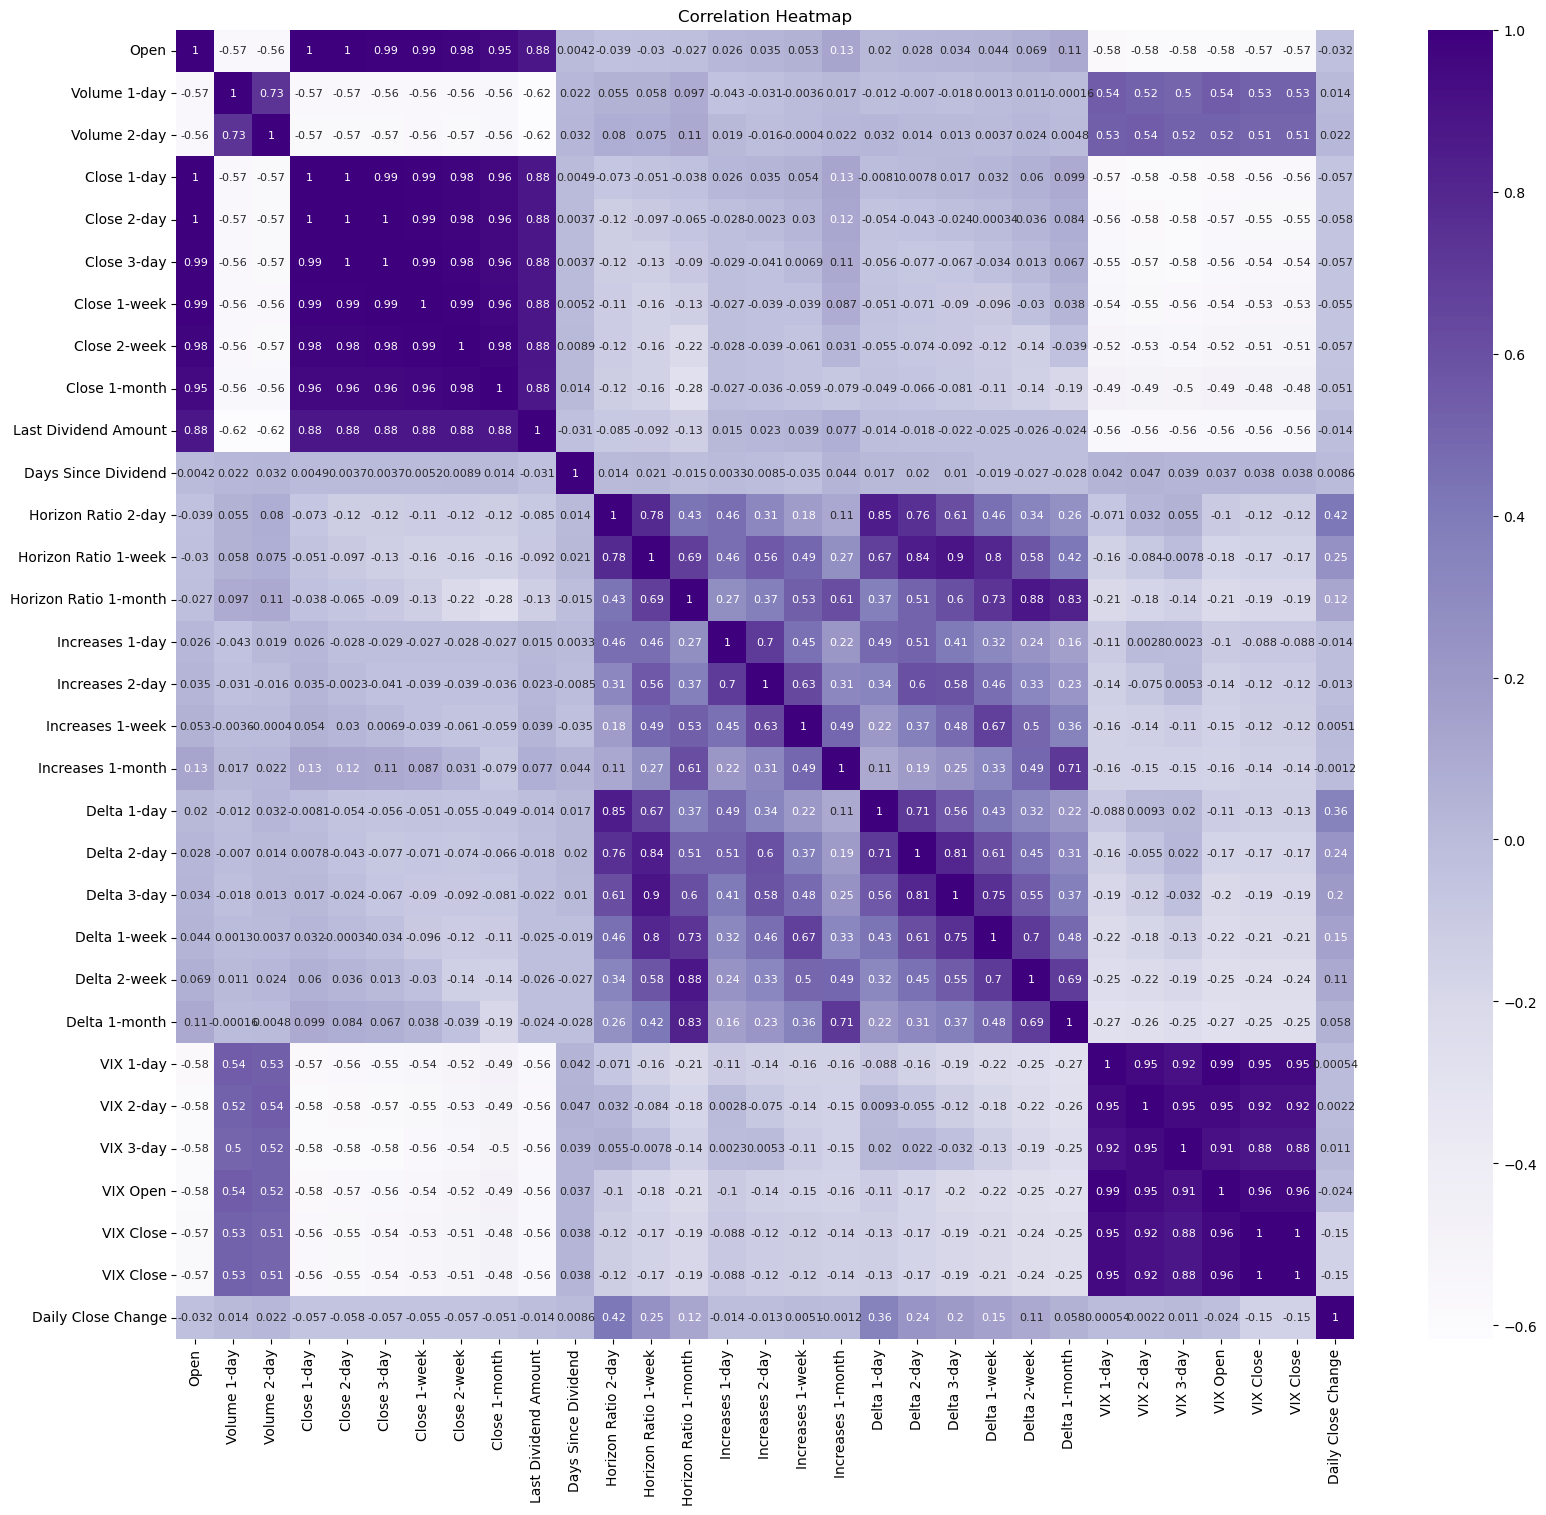

In [30]:
#Correlation Heatmap
predict_features = ['VIX Close', 'Daily Close Change'] #These values are not available at the time of prediction

combined_features = numerical_features + predict_features
corr_data = nom_data[combined_features]

#Correlation
corr = corr_data.corr()
plt.figure(figsize=(19,17), facecolor ='w')
sns.heatmap(corr, annot=True, cmap='Purples', annot_kws={"size": 8}) 
plt.title('Correlation Heatmap')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()



#### Distribution of Deltas in Closing Prices

 While the overall stock price does not follow a standard (bell-shaped) distribution, the daily price changes (deltas) appear to form an approximately bell-shaped curve. This indicates that small corrections in the stock value occur more frequently, whereas large price changes—either positive or negative—are relatively rare.

Additionally, the mean of the distribution is slightly offset to the right (around 0.11), which aligns with the observation that this stock has generally been trending upward over the examined period.

Although not explored here, future research could leverage this distribution to estimate the potential magnitude of price changes, thereby offering additional insights for traders.

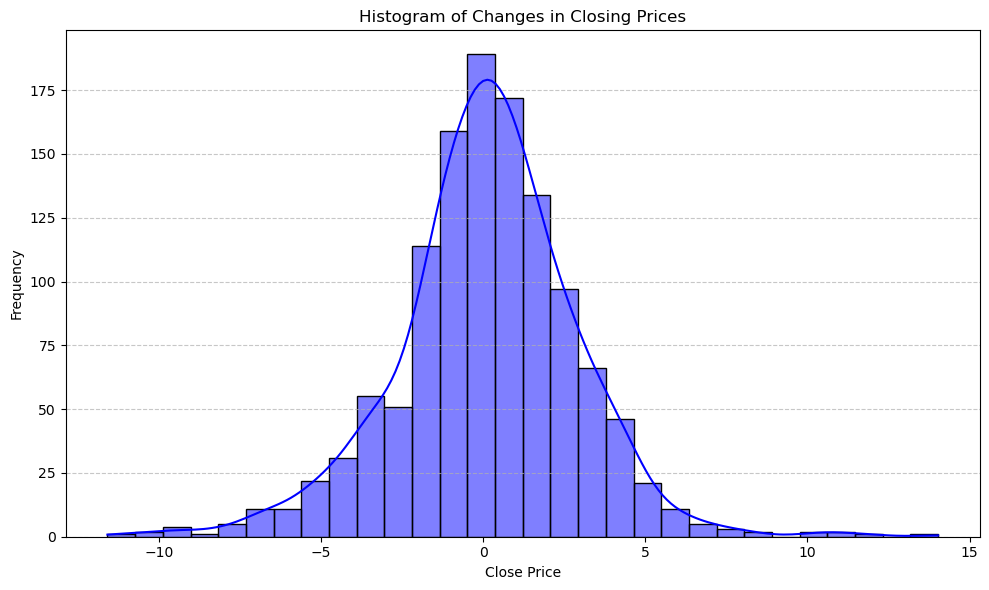

,Daily Close Change
count,1219.000000
mean,0.111095
std,2.798601
min,-11.590011
25%,-1.358749
50%,0.169998
75%,1.690002
max,14.029999


In [31]:


# Create a histogram of the Daily Close Change
plt.figure(figsize=(10, 6))
sns.histplot(nom_data['Daily Close Change'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Changes in Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

nom_data[['Daily Close Change']].describe()

## Modeling

With the whether the stock price will go up or down as the target, different regression models will be evaluated. As part of the models, different parameters will be explored and the findings will be cross-validated. 

1. Select Modeling Technique
2. Generate Test Design - Split Test and Training Data
3. Build Model
4. Assess Model




### 1. Select Modeling Technique 

Various categorization models are evaluated. Metrics are collected. These metrics will be applied to the testing (dev) set as there can be overfitting with the training set. The following evaluation metrics will be used to rate each model:

**Accuracy Score**

Accuracy is the number of correct predictions divided by the number of predictions and is a good starting point for general effectiveness of the model. However there are better metrics for this use case. 

**Precision Score**

In this scenario, we only buy when the model tells us to. We want to minimize the number of false positives as false positives cause us to lose money. Recall is the ratio of true positives over true and false positives.  This metric correctly penalizes false positivies but there may be some missed opportunities in the form of false negatives. 

**Recall Score**

Defined as the ratio of true positives over true positives and false negatives, this metrc helps us catch all opportunities as it penalizes missed opporrtunites (false negatives).







<center>
    <img src = "images/wikipedia-confusion_matrix.png" width = 70%/>
</center>


<center>Source: Wikipedia </center>

In [32]:
#Build Cross Validation Table to compare RMSE of different models
modeling_cross_validation = pd.DataFrame(columns=[
    "Model Name", 
    "Train Time (sec)", 
    "Train Predict Time (sec)",
    "Train Accuracy",
    "Test Accuracy", 
    "Test Precision Score", "Test Recall Score"])

modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score


### 2. Generate Test Design - Split Test and Training Data

The overall cleaned dataset will be split into a Training dataset used for training the models, and Dev Test dataset used to validate the model.  Twenty-five percent of the dataset will be used tor Dev Test, and the remaining 75% will be used for training. 

In [33]:
#Generate Test Design
# Split Test and Train

X = nom_data[numerical_features]
y = nom_data['Up or Down'] 

train = nom_data.iloc[:-100]
test = nom_data.iloc[-100:]

# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True)

#Split with last 100
#X_train = X.iloc[:-100]
#X_test = X.iloc[-100:]
#y_train = y.iloc[:-100]
#y_test = y.iloc[-100:]


### 3. Build Model
Several models will be built. Accuracy will be used to assess each model. Training and Test errors will be recorded. Grid Search will be used to tune hyperparameters and perform the cross-validation. 


#### Perform PCA 
First, continuing with the Exploratory Data Analysis (EDA), Principal Component Analysis (PCA) is used to help feature selection by understanding which features are uncorrelated and important. This could be used so that data is not skewed and processing is faster. 

In [34]:
# Applying PCA function on training
# and testing set of X component

pca = PCA(n_components=5)
data_in=nom_data[numerical_features]
scaled_nom_data = StandardScaler().fit_transform(data_in)
pdax = pca.fit_transform(scaled_nom_data)

# Create a sorted list of features based on the sum of their absolute contributions across all principal components
features = data_in.columns
components = pca.components_

# Calculate the sum of absolute values of each feature's contribution across all components
feature_contributions = np.sum(np.abs(components), axis=0)

# Create a DataFrame for better visualization
contributions_df = pd.DataFrame({'Feature': features, 'Sum of Contributions': feature_contributions})

# Sort the DataFrame by the sum of contributions in descending order
sorted_contributions = contributions_df.sort_values(by='Sum of Contributions', ascending=False)

# Display sorted contributions
sorted_contributions



,Feature,Sum of Contributions
11,Horizon Ratio 2-day,1.055318
23,Delta 1-month,1.040517
18,Delta 1-day,0.982360
15,Increases 2-day,0.964064
14,Increases 1-day,0.944805
16,Increases 1-week,0.941224
13,Horizon Ratio 1-month,0.897074
17,Increases 1-month,0.874580
24,VIX 1-day,0.859483
22,Delta 2-week,0.852156


### 3. Build Models

#### Model : KNN


In [35]:

knn_pipe = Pipeline([('transform', preprocessor), 
                     ('knn', KNeighborsClassifier())])

start = time.time()
knn_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = knn_pipe.predict(X_train)
predict_secs = time.time()-start 

test_preds = knn_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "K Nearest Neighbors", 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.recall_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation


,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524


#### Assess Model: KNN - Revise Parameter Settings 

Optimize hyperparameter 'k' for nearest neighbor. The GridSearch CV algorithm found that 62 nearest neighbors was the most optimal.

In [36]:

parameters_values = np.array(range(1,100))

parameters = {'knn__n_neighbors': parameters_values }

knn_pipe_search = GridSearchCV(estimator = knn_pipe, 
                               param_grid = parameters, 
                               scoring = "accuracy",
                               cv = 5)

knn_pipe_search.fit(X_train, y_train)
knn_pipe_search.best_estimator_


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('scal', StandardScaler(),
                                                  ['Open', 'Volume 1-day',
                                                   'Volume 2-day',
                                                   'Close 1-day', 'Close 2-day',
                                                   'Close 3-day',
                                                   'Close 1-week',
                                                   'Close 2-week',
                                                   'Close 1-month',
                                                   'Last Dividend Amount',
                                                   'Days Since Dividend',
                                                   'Horizon Ratio 2-day',
                                                   'Horizon Ratio 1-week',
                                                   'Horizon Ratio 1-month',
                                                   'Increases 1-day',
                                                   'Increases 2-day',
                                                   'Increases 1-week',
                                                   'Increases 1-month',
                                                   'Delta 1-day', 'Delta 2-day',
                                                   'Delta 3-day',
                                                   'Delta 1-week',
                                                   'Delta 2-week',
                                                   'Delta 1-month', 'VIX 1-day',
                                                   'VIX 2-day', 'VIX 3-day',
                                                   'VIX Open',
                                                   'VIX Close'])])),
                ('knn', KNeighborsClassifier(n_neighbors=62))])

In [37]:
gridsearch_output = pd.DataFrame({'CV accuracy': knn_pipe_search.cv_results_['mean_test_score'],
             'k': parameters_values})
fig = px.line(gridsearch_output, x = "k", y = "CV accuracy", title="KNN Tree Hyperparameter Tuning: CV Accuracy vs k-nearest neighbors")
fig.show()

In [38]:

start = time.time()
knn_pipe_search.best_estimator_.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = knn_pipe_search.best_estimator_.predict(X_train)
predict_secs = time.time()-start 
test_preds = knn_pipe_search.best_estimator_.predict(X_test)


modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "K Nearest Neighbors Tuning - k: " + str(knn_pipe_search.best_params_['knn__n_neighbors']) , 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.recall_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation


,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524
1,K Nearest Neighbors Tuning - k: 62,0.005482,0.028088,0.607221,0.557377,0.589189,0.648810


#### Model: Decision Tree
Using default values, a tree of depth of 15 was produced.

In [39]:
dt_pipe = Pipeline([('transform', preprocessor), 
                     ('dtc',DecisionTreeClassifier())])

start = time.time()
dt_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = dt_pipe.predict(X_train)
predict_secs = time.time()-start 
test_preds = dt_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Decision Tree -  Depth: " + str(dt_pipe['dtc'].get_depth()),
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.recall_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524
1,K Nearest Neighbors Tuning - k: 62,0.005482,0.028088,0.607221,0.557377,0.589189,0.648810
2,Decision Tree - Depth: 15,0.025760,0.002096,1.000000,0.600000,0.627778,0.672619


#### Assess Model: Decision Tree - Revise Parameter Settings 

Optimize hyperparameter 'max_depth' for Decision Tree. Values from 1 to 33 are tried. Compared to the default settings which produced a tree of depth of 15, GridSearchCV identified a flat tree of max_depth=1 as optimal which produced a slightly higher test accuracy, but with slightly lower real world performance with percision.

In [40]:
parameters_values = np.array(range(1,33))
parameters = {'dtc__max_depth': parameters_values}


dtc_pipe_search = GridSearchCV(estimator = dt_pipe, 
                               param_grid = parameters, 
                               scoring = "accuracy")

dtc_pipe_search.fit(X_train, y_train)
dtc_pipe_search.best_estimator_


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('scal', StandardScaler(),
                                                  ['Open', 'Volume 1-day',
                                                   'Volume 2-day',
                                                   'Close 1-day', 'Close 2-day',
                                                   'Close 3-day',
                                                   'Close 1-week',
                                                   'Close 2-week',
                                                   'Close 1-month',
                                                   'Last Dividend Amount',
                                                   'Days Since Dividend',
                                                   'Horizon Ratio 2-day',
                                                   'Horizon Ratio 1-week',
                                                   'Horizon Ratio 1-month',
                                                   'Increases 1-day',
                                                   'Increases 2-day',
                                                   'Increases 1-week',
                                                   'Increases 1-month',
                                                   'Delta 1-day', 'Delta 2-day',
                                                   'Delta 3-day',
                                                   'Delta 1-week',
                                                   'Delta 2-week',
                                                   'Delta 1-month', 'VIX 1-day',
                                                   'VIX 2-day', 'VIX 3-day',
                                                   'VIX Open',
                                                   'VIX Close'])])),
                ('dtc', DecisionTreeClassifier(max_depth=1))])

In [41]:


start = time.time()
dtc_pipe_search.best_estimator_.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = dtc_pipe_search.best_estimator_.predict(X_train)
predict_secs = time.time()-start 
test_preds = dtc_pipe_search.best_estimator_.predict(X_test)


modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Decision Tree Tuning - Max Depth: " + str(dtc_pipe_search.best_estimator_['dtc'].tree_.max_depth ), 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.recall_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation



,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524
1,K Nearest Neighbors Tuning - k: 62,0.005482,0.028088,0.607221,0.557377,0.589189,0.648810
2,Decision Tree - Depth: 15,0.025760,0.002096,1.000000,0.600000,0.627778,0.672619
3,Decision Tree Tuning - Max Depth: 1,0.007538,0.001558,0.631291,0.606557,0.627660,0.702381


In [42]:
dtc_pipe_search.best_estimator_['dtc'].tree_.max_depth

1

#### Model: Random Forest Classifier

In [43]:
#Random Forest Classifier
rfc_pipe = Pipeline([('transform', preprocessor), 
                     ('rfc', RandomForestClassifier(n_estimators=100,
                                                    min_samples_split=100))])

start = time.time()
rfc_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_probs = rfc_pipe.predict_proba(X_train)[:, 1]
train_preds = np.where(train_probs > 0.6, 'UP', 'DOWN')
predict_secs = time.time()-start 
test_preds = rfc_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Random Forest Classifier", 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.recall_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524
1,K Nearest Neighbors Tuning - k: 62,0.005482,0.028088,0.607221,0.557377,0.589189,0.648810
2,Decision Tree - Depth: 15,0.025760,0.002096,1.000000,0.600000,0.627778,0.672619
3,Decision Tree Tuning - Max Depth: 1,0.007538,0.001558,0.631291,0.606557,0.627660,0.702381
4,Random Forest Classifier,0.155698,0.006933,0.723195,0.619672,0.628713,0.755952


#### Model: SVM (Support Vector Machine)

In [44]:
# SVM

svm_pipe = Pipeline([('transform', preprocessor), 
                     ('svc',SVC())])

start = time.time()
svm_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = svm_pipe.predict(X_train)
predict_secs = time.time()-start 
test_preds = svm_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "SVM Tree", 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.recall_score(y_test, test_preds, pos_label='UP')
   ]


modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524
1,K Nearest Neighbors Tuning - k: 62,0.005482,0.028088,0.607221,0.557377,0.589189,0.648810
2,Decision Tree - Depth: 15,0.025760,0.002096,1.000000,0.600000,0.627778,0.672619
3,Decision Tree Tuning - Max Depth: 1,0.007538,0.001558,0.631291,0.606557,0.627660,0.702381
4,Random Forest Classifier,0.155698,0.006933,0.723195,0.619672,0.628713,0.755952
5,SVM Tree,0.023717,0.036089,0.763676,0.649180,0.650246,0.785714


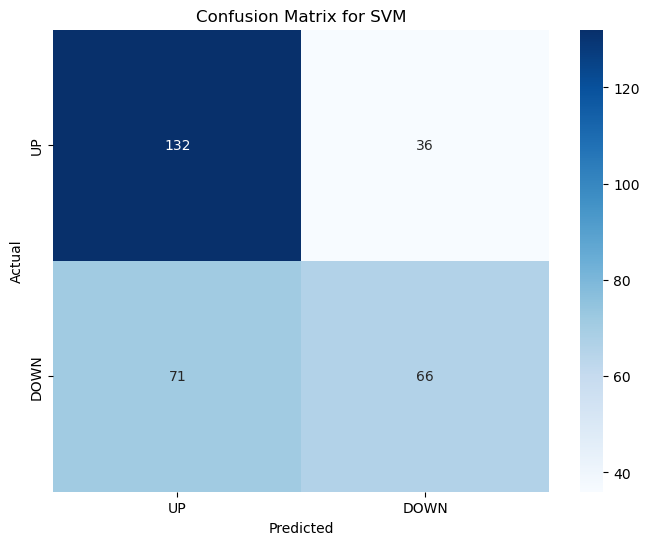

In [45]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, test_preds, labels=['UP', 'DOWN'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['UP', 'DOWN'], yticklabels=['UP', 'DOWN'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4. Assess Model

In [46]:
modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Precision Score,Test Recall Score
0,K Nearest Neighbors,0.009261,0.081676,0.710066,0.518033,0.562874,0.559524
1,K Nearest Neighbors Tuning - k: 62,0.005482,0.028088,0.607221,0.557377,0.589189,0.648810
2,Decision Tree - Depth: 15,0.025760,0.002096,1.000000,0.600000,0.627778,0.672619
3,Decision Tree Tuning - Max Depth: 1,0.007538,0.001558,0.631291,0.606557,0.627660,0.702381
4,Random Forest Classifier,0.155698,0.006933,0.723195,0.619672,0.628713,0.755952
5,SVM Tree,0.023717,0.036089,0.763676,0.649180,0.650246,0.785714
